# Extract info about queries with supplementary mappings

- Write csv with info about queries with supplementary mappings
- Plot reference starting positions of primary vs supplementary mappings

## Create table

In [1]:
import pysam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def supp_query_list(sam_file):
    '''
    Return a list of query names with supplementary mappings on a SAM file.
    '''
    supplementary = []
    with pysam.AlignmentFile(sam_file) as af:
        for read in af:
            if read.is_supplementary:
                supplementary.append(read.query_name)
    return np.unique(supplementary)

In [3]:
def get_real_query_start_end(sam_start, sam_end, query_length, cigar_tuples, forward):
    '''
    Return tuple of start and end position of query on reference.
    '''
    hc = 0 if cigar_tuples[0][0] != 5 else cigar_tuples[0][1]
    if forward:
        return sam_start + hc, sam_end + hc
    else:
        return query_length - hc - sam_start, query_length - hc - sam_end

In [4]:
sam_file = "../results/2022-09-21_amoxicillin_run_vial_14_time_14/reads.sorted.bam"
csv_file = "../results/2022-09-21_amoxicillin_run_vial_14_time_14/suppl_reads_info.csv"

# Write csv with info about queries with supplementary mappings
supplementary = supp_query_list(sam_file)
df = []
with pysam.AlignmentFile(sam_file) as af:
    for read in af:
            if read.query_name in supplementary:
                mapping_type = 'primary'
                if read.is_secondary:
                    mapping_type = 'secondary'
                elif read.is_supplementary:
                    mapping_type = 'supplementary'
                query_start, query_end = get_real_query_start_end(read.query_alignment_start, read.query_alignment_end,
                                                                  read.infer_read_length(), read.cigartuples, read.is_forward)
                df.append({
                    "query_name" : read.query_name,
                    "is_forward" : read.is_forward,
                    "type" : mapping_type,
                    "ref_start" : read.reference_start,
                    "ref_end" : read.reference_end,
                    "query_start" : query_start,
                    "query_end" : query_end,
                    "alignment_length" : read.query_alignment_length,
                    "query_length" : read.infer_read_length(),
                    "matches" : read.get_cigar_stats()[0][0],
                    "insertions" : read.get_cigar_stats()[0][1],
                    "deletions" : read.get_cigar_stats()[0][2],
                    "soft_clips" : read.get_cigar_stats()[0][4],
                    "hard_clips" : read.get_cigar_stats()[0][5],                
                })
df = pd.DataFrame(df)
df.to_csv(csv_file)
df

,query_name,is_forward,type,ref_start,ref_end,query_start,query_end,alignment_length,query_length,matches,insertions,deletions,soft_clips,hard_clips
0,efe12add-b1d0-4e41-aebd-eed2fa78f7ee,True,supplementary,0,9048,14894,23903,9009,23904,8872,137,176,0,14895
1,2fe479f7-1996-490c-9874-6675a008591f,True,primary,0,5072,2752,7762,5010,7763,4946,64,126,2753,0
2,d223e17a-92da-4a23-b1da-b4eb2e282b26,True,primary,0,7012,2234,9121,6887,9121,6781,106,231,2234,0
3,a3dbcae7-9ad6-42dc-ad8c-4861908e2de3,True,supplementary,0,2368,3622,5964,2342,5966,2329,13,39,0,3624
4,4eeb1139-5230-4610-8556-d11a91813679,True,primary,0,30303,4207,34541,30334,34550,29883,451,420,4216,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,6d097e01-2eff-4ae6-98dc-8324d5350a1f,True,supplementary,4643349,4643630,0,267,267,8984,266,1,15,0,8717
620,c2cab184-d626-4cde-9f42-a49ba97e1922,False,supplementary,4643391,4643630,7989,7753,236,7992,230,6,9,0,7756
621,65814ead-234f-4aa4-a9bb-d218fa4230b3,False,supplementary,4643394,4643630,9119,8883,236,9141,234,2,2,0,8905
622,f1276b05-d22d-459e-a599-7b6ce6cb93d0,True,supplementary,4643479,4643630,0,147,147,2455,146,1,5,0,2308


## Create list of dicts for each query

In [5]:
query_ids = []
for s in supplementary:
    prim = 0
    sec = []
    supp = []
    for row in df.itertuples():
        if row.query_name == s:
            if row.type == "secondary":
                sec.append(row.ref_start)
            elif row.type == "supplementary":
                supp.append(row.ref_start)
            else:
                prim = row.ref_start
    query_ids.append({
        "query_name" : s,
        "primary" : prim,
        "secondary" : sec,
        "supplementary" : supp
    })

## Export distant mappings

In [6]:
distant = []
for q in query_ids:
    p = q["primary"]
    for s in q["supplementary"]:
        if np.abs(s-p) > 1e5 and np.abs(s-p) < 4e6:
            distant.append(q["query_name"])
distant = np.unique(distant)

distant_df = []
for d in distant:
    distant_df.append({
        "query_name" : d
    })
distant_df = pd.DataFrame(distant_df)
distant_df.to_csv("../results/2022-09-21_amoxicillin_run_vial_14_time_14/distant_mappings.csv")

## Plot primary vs secondary starts for queries with supplementary mappings

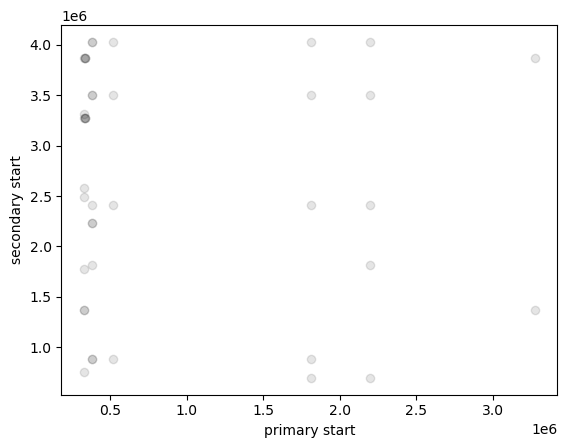

In [7]:
for q in query_ids:
    for s in q["secondary"]:
        plt.scatter(q["primary"],s,c="k", alpha=0.1)
plt.xlabel("primary start")
plt.ylabel("secondary start")
plt.savefig("../results/2022-09-21_amoxicillin_run_vial_14_time_14/figures/extract_suppl_secondary.png")
plt.show()

- multiple secondary mappings for each primary
- regular spacing due to different combinations of multiple sequences 

## Plot primary vs supplementary starts

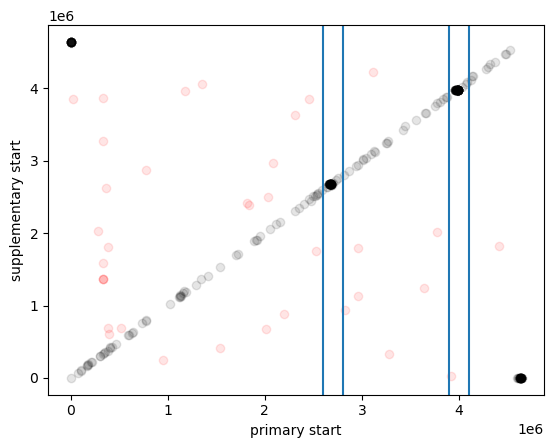

In [8]:
for q in query_ids:
    for s in q["supplementary"]:
        p = q["primary"]
        color = "r" if (np.abs(s-p) > 1e5 and np.abs(s-p) < 4e6) else "k"
        plt.scatter(q["primary"],s,c=color,alpha=0.1)
plt.axvline(2.6e6)
plt.axvline(2.8e6)        
plt.axvline(3.9e6)
plt.axvline(4.1e6)
plt.xlabel("primary start")
plt.ylabel("supplementary start")
plt.savefig("../results/2022-09-21_amoxicillin_run_vial_14_time_14/figures/extract_suppl_supplementary.png")
plt.show()

- most supplementary are around their corresponding primary mappings
- many start/end combinations due to sequences including origin
- 2 regions with high density around 2.7 and 4.0 Mbp